In [3]:
import socket

host = "localhost"
port = 5432

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
result = sock.connect_ex((host, port))
if result == 0:
    print(f"Connection to {host}:{port} successful!")
else:
    print(f"Failed to connect to {host}:{port}")
sock.close()



Connection to localhost:5432 successful!


In [4]:


import pandas as pd 
from sqlalchemy import create_engine

DB_HOST="localhost"  
DB_PORT="5432"
DB_NAME="otodom"
DB_USER="postgres"
DB_PASSWORD="postgres"

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

df = pd.read_sql("SELECT * FROM listings", engine)
df.head()


,id,price,district,rooms,area,seller_type
0,1,1199000.0,Grunwald,3.0,63.54,Oferta prywatna
1,2,405000.0,Stare Miasto,2.0,30.00,Oferta prywatna
2,3,679000.0,Stare Miasto,4.0,64.90,Oferta prywatna
3,4,425000.0,Stare Miasto,1.0,29.20,Biuro nieruchomości
4,5,650000.0,Stare Miasto,3.0,53.00,Oferta prywatna


## Clean and preview data. Key initial insights

In [5]:
df.isnull().sum()
df.info()
df.describe()
df.head()

df_clean = df.dropna(subset=['rooms', 'area'])
df_clean = df_clean[(df_clean['rooms'] > 0) & (df_clean['area'] > 0)]

df_clean["price_per_sqm"] = (df_clean["price"] / df_clean["area"]).round(2)
df_clean.head()



avg_apartamet_size = df_clean['area'].mean().round(2)
print(f"Average apartment size: {avg_apartamet_size} sqm")
median_apartamet_size = df_clean['area'].median().round(2)
print(f"Median apartment size: {median_apartamet_size} sqm")
avg_price_per_sqm = df_clean['price_per_sqm'].mean().round(2)
print(f"Average price per square meter: {avg_price_per_sqm} PLN/sqm")
median_price_per_sqm = df_clean['price_per_sqm'].median().round(2)
print(f"Median price per square meter: {median_price_per_sqm} PLN/sqm")
avg_rooms = df_clean['rooms'].mean().round(2)
median_rooms = df_clean['rooms'].median().round(2)
print(f"Average rooms: {avg_rooms}, Median rooms: {median_rooms}")





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           900 non-null    int64  
 1   price        722 non-null    float64
 2   district     900 non-null    object 
 3   rooms        898 non-null    float64
 4   area         898 non-null    float64
 5   seller_type  695 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 42.3+ KB
Average apartment size: 55.14 sqm
Median apartment size: 52.1 sqm
Average price per square meter: 12195.18 PLN/sqm
Median price per square meter: 12236.84 PLN/sqm
Average rooms: 2.45, Median rooms: 2.0


## Insights
This dataset contains 900 apartment listings with information on id, price, district, rooms, area, and seller_type. Some columns have missing values: price (722 non-null), rooms (898 non-null), area (898 non-null), and seller_type (695 non-null).

# Key summary statistics:

- Apartment size: The average area is 55.14 sqm, with a median of 52.1 sqm, indicating most apartments are moderately sized.

- Price per square meter: Average is 12,195.18 PLN/sqm, and the median is 12,236.84 PLN/sqm, showing a fairly consistent pricing trend per sqm.

- Number of rooms: The average is 2.45 rooms, with a median of 2 rooms, suggesting most apartments have 2–3 rooms.

## Visualization
- Price per Square Meter Distribution distribution 
- Price vs Area scatter plot

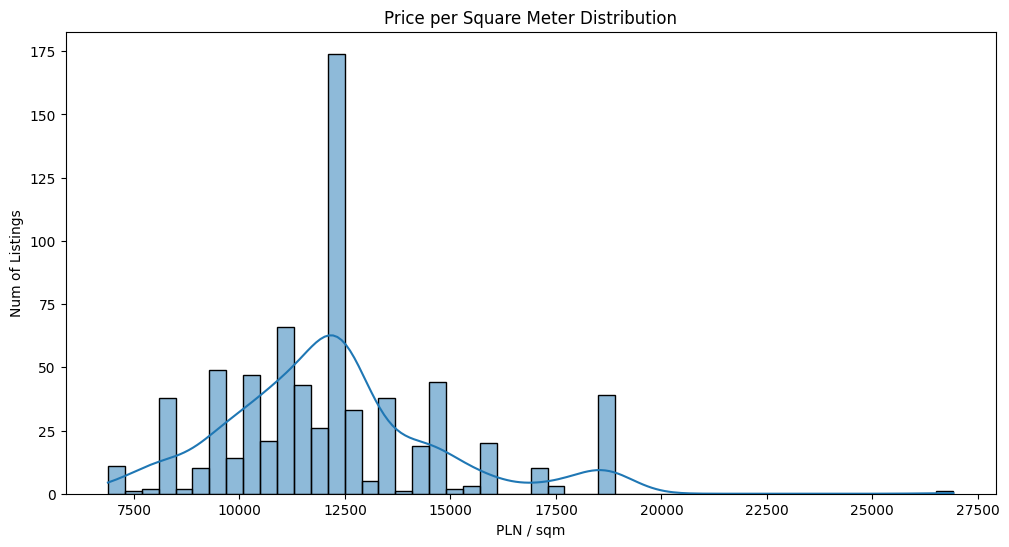

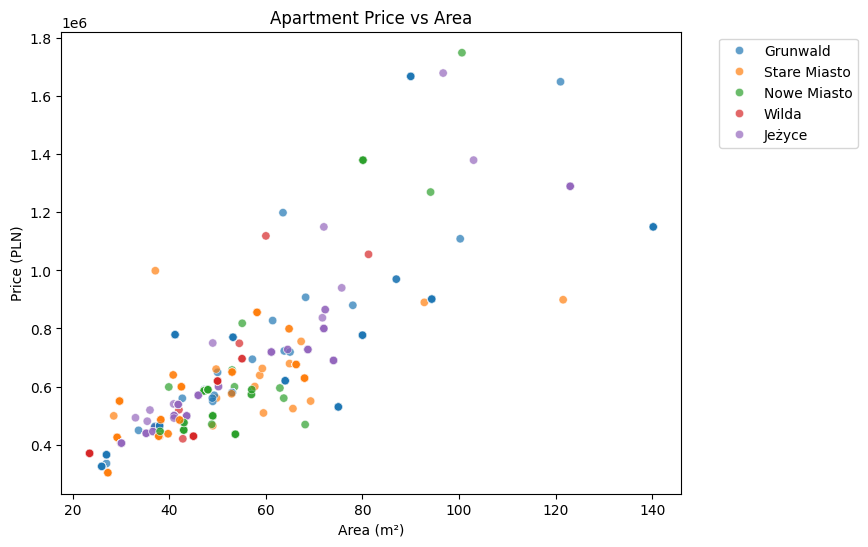

In [6]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price_per_sqm'], bins=50, kde=True)
plt.title('Price per Square Meter Distribution')
plt.xlabel('PLN / sqm')
plt.ylabel('Num of Listings')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area', y='price', data=df_clean, hue='district', alpha=0.7)
plt.title('Apartment Price vs Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price (PLN)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



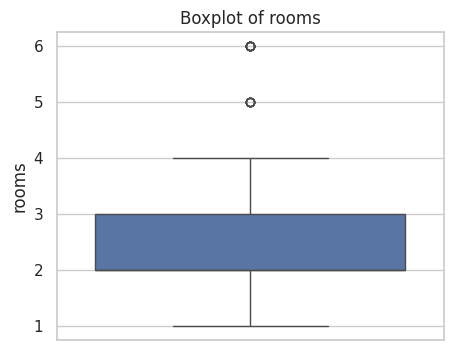

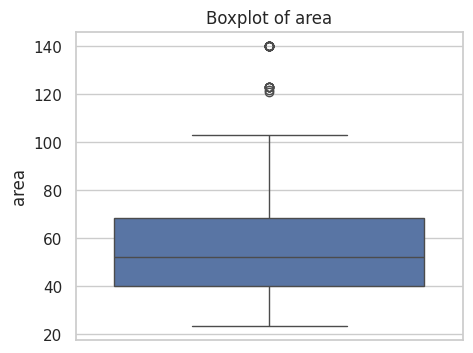

In [16]:
sns.set(style="whitegrid")
numeric_cols = ['rooms', 'area']

for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

There are some outliers, expecially in 'area'.

## DISTRICT LEVEL ANALYSIS


In [19]:
df_clean = df_clean[df_clean['price_per_sqm'].notna() & df_clean['price_per_sqm'].apply(lambda x: x != float('inf'))]
# average price, area and listings count per district
district_stats = df_clean.groupby('district').agg({
    'price_per_sqm' : 'mean',
    'area' : 'mean',
    'id' : 'count'
}).rename(columns={'id' : 'listings_count'})
district_stats = district_stats.round(2)
district_stats.sort_values(by='price_per_sqm', ascending=False, inplace=True)
district_stats 


,price_per_sqm,area,listings_count
district,,,
Stare Miasto,13178.86,43.77,175
Wilda,13175.43,39.71,51
Jeżyce,11923.78,52.60,222
Grunwald,11757.24,67.03,170
Nowe Miasto,11354.44,52.69,104


# Insights

- Stare Miasto has the highest average price per sqm (13,178.86) and a moderate average area (43.77 sqm) with 175 listings.
- Wilda has a similar price per sqm (13,175.43) but smaller properties on average (39.71 sqm) and fewer listings (51).
- Jeżyce and Grunwald offer larger properties (52.6 sqm and 67.03 sqm, respectively) but at slightly lower prices per sqm (11,923.78 and 11,757.24). Jeżyce also has the most listings (222).
- Nowe Miasto shows a moderate price per sqm (11,354.44) with medium-sized properties (52.69 sqm) and 104 listings.

## Room count per district

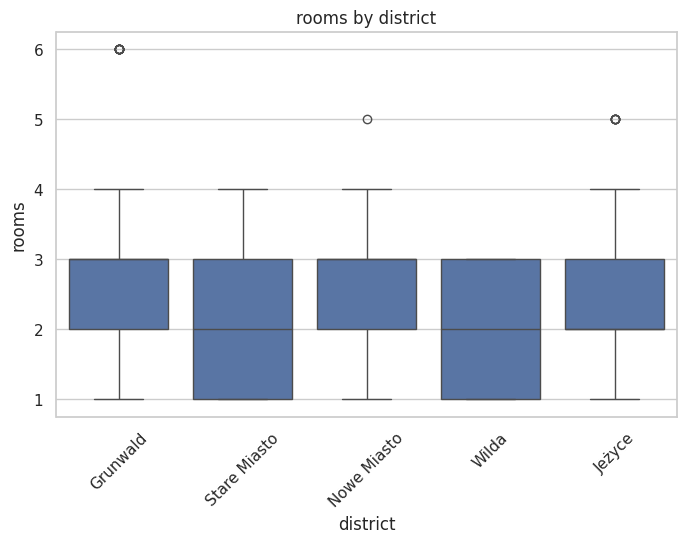

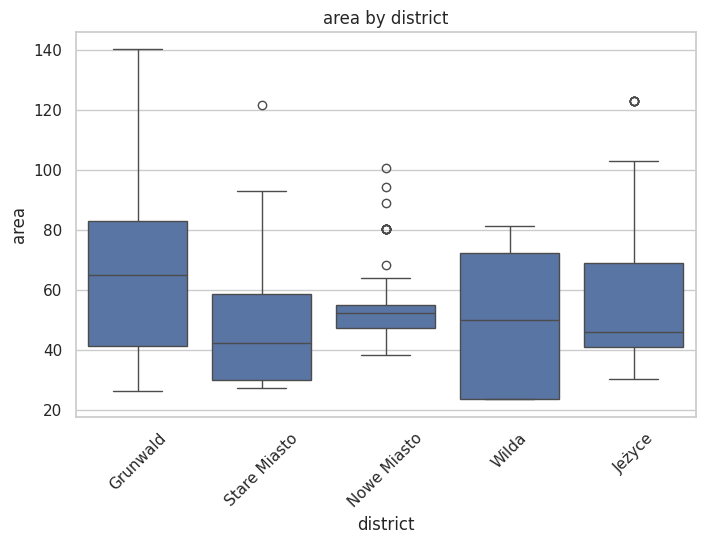

In [19]:
categorical_cols = ['district']

for num_col in numeric_cols:
    for cat_col in categorical_cols:
        plt.figure(figsize=(8,5))
        sns.boxplot(x=cat_col, y=num_col, data=df_clean)
        plt.title(f'{num_col} by {cat_col}')
        plt.xticks(rotation=45)
        plt.show()

There are some outliers in 'Nowe Miasto' district when it comes to the apartament size.

In [20]:
#Room count average per district
district_rooms = df_clean.groupby('district')['rooms'].mean().round(2).rename('avg_rooms')
district_rooms


district
Grunwald        2.72
Jeżyce          2.48
Nowe Miasto     2.81
Stare Miasto    2.07
Wilda           2.18
Name: avg_rooms, dtype: float64

## Insights
- Grunwald (2.72) and Jeżyce (2.48) also feature moderately sized apartments in terms of rooms.
- Wilda (2.18) and Stare Miasto (2.07) have the smallest average number of rooms, suggesting smaller or more compact apartments.

In general, central districts like Stare Miasto and Wilda tend to have smaller apartments, while districts such as Nowe Miasto and Grunwald offer slightly larger living spaces.

## Price dispersion

In [21]:
#Price dispersion
district_spread = df_clean.groupby('district')['price_per_sqm'].agg(['mean', 'std', 'min', 'max'])
district_spread['range'] = district_spread['max'] - district_spread['min']
district_spread = district_spread.round(2)
district_spread

,mean,std,min,max,range
district,,,,,
Grunwald,11757.24,3175.51,7064.00,18900.00,11836.00
Jeżyce,11923.78,1090.68,9324.32,17373.32,8049.00
Nowe Miasto,11354.44,2619.03,6883.90,17397.36,10513.46
Stare Miasto,13178.86,2834.80,7396.74,26919.97,19523.23
Wilda,13175.43,2503.29,9533.33,18650.00,9116.67


## Seller type by district

In [22]:
seller_type_stats = df_clean.groupby(['district', 'seller_type']).size().unstack(fill_value=0)

# normalize the counts to get percentages
seller_type_stats = seller_type_stats.div(seller_type_stats.sum(axis=1), axis=0) * 100
seller_type_stats = seller_type_stats.round(2)
seller_type_stats = seller_type_stats.fillna(0)
seller_type_stats



seller_type,Biuro nieruchomości,Deweloper,Oferta prywatna
district,,,
Grunwald,61.49,0.68,37.84
Jeżyce,89.59,0.00,10.41
Nowe Miasto,93.14,0.98,5.88
Stare Miasto,64.94,0.00,35.06
Wilda,50.98,0.00,49.02


## Insights
- Grunwald: Most properties are listed by real estate agencies (61.49%), a smaller portion are private offers (37.84%), and very few by developers (0.68%).
- Jeżyce and Nowe Miasto: Dominated by real estate agencies (89.59% and 93.14%, respectively) with very few private offers and almost no developer listings.
- Stare Miasto: A more balanced mix, with 57.80% through agencies, 31.21% private, and a notable 10.98% from developers.
- Wilda: Almost half of listings are private (49.02%) and the rest primarily through agencies (50.98%), with no developer listings.

Overall, central and popular districts like Jeżyce and Nowe Miasto rely heavily on agencies, while peripheral or mixed districts like Wilda and Stare Miasto show a stronger presence of private offers and, in some cases, developers.

## Seller type distribution - visualization

<Figure size 1200x600 with 0 Axes>

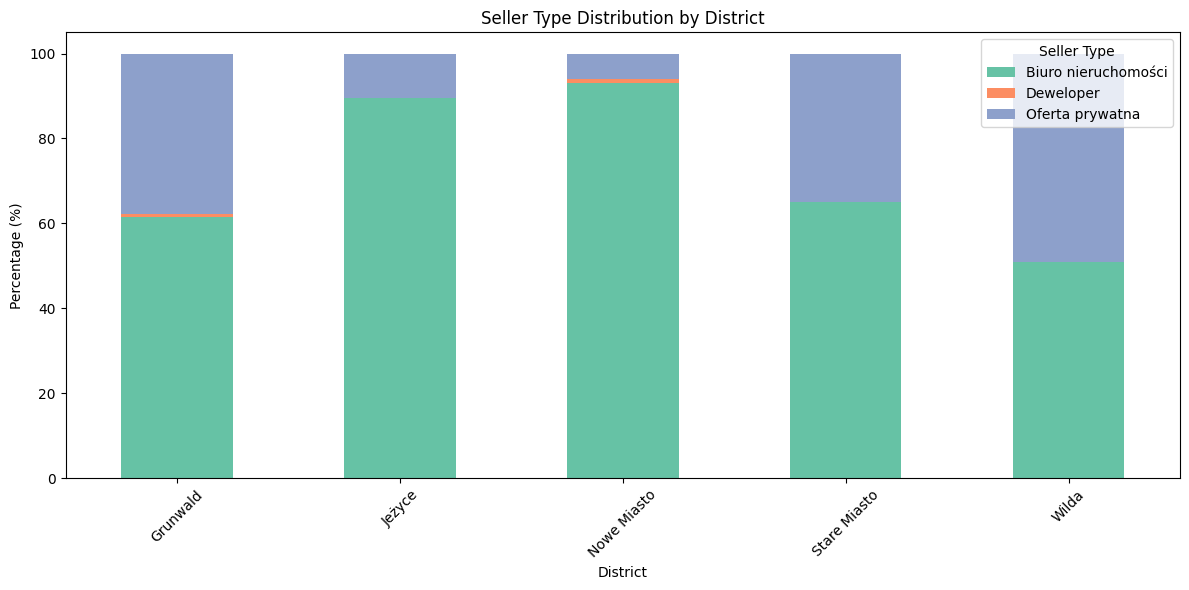

In [23]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2")  # or "pastel", "husl", "coolwarm", "cubehelix"
seller_type_stats.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(12, 6)
)
plt.title('Seller Type Distribution by District')
plt.xlabel('District')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Seller Type')
plt.tight_layout()
plt.show()

## LINEAR REGRESSION


In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Mapping district distances from the city centre (in km)
district_distances = {
    'Jeżyce': 3.5,
    'Wilda': 4.0,
    'Nowe Miasto': 2.5,
    'Stare Miasto': 0.5,
    'Grunwald': 5.0,
    'Łazarz': 3.0,
}
df_clean['distance_km'] = df_clean['district'].map(district_distances)

# Dropping rows with missing values in important columns
df_clean = df_clean[['rooms', 'area', 'seller_type', 'district', 'price', 'distance_km']].dropna()

# Converting district into binary columns to use in regression
df_encoded = pd.get_dummies(df_clean, columns=['district'], drop_first=True)

# Adding polynomial term for area (area squared)  -- modification of the linear model
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_area = poly.fit_transform(df_encoded[['area']])
df_encoded['area'] = poly_area[:, 0] 
df_encoded['area_sq'] = poly_area[:, 1] 

# Adding interaction terms between area and districts -- modification of the linear model
district_cols = [col for col in df_encoded.columns if col.startswith('district_')]

for col in district_cols:
    df_encoded[f'area_{col}'] = df_encoded['area'] * df_encoded[col]

feature_cols = ['area', 'area_sq', 'distance_km'] + district_cols + [f'area_{col}' for col in district_cols]

X = df_encoded[feature_cols]
y = df_encoded['price']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Scaling features to standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


# Fitting linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = (rmse * 100 / np.mean(y)).round(2)

print(f"Coefficient of variation: {cv}%")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


# Coefficients and intercept
coefficients = pd.Series(model.coef_, index=feature_cols)
print("Coefficients:")
print((coefficients.sort_values(ascending=False)).round(2))

intercept = model.intercept_
print(f"Intercept: {intercept:.2f}")


# Variable relevance
import statsmodels.api as sm

# Converting boolean columns to int for statsmodels compatibility
X_sm_int = sm.add_constant(X.astype(float))
model_sm = sm.OLS(y, X_sm_int).fit()
print(model_sm.summary())



Coefficient of variation: 15.18%
Root Mean Squared Error: 91288.96
R^2 Score: 0.78
Coefficients:
area_district_Nowe Miasto     283167.38
area                          202066.08
district_Stare Miasto          86713.99
area_district_Jeżyce           66521.04
distance_km                    43475.82
area_district_Wilda            32517.69
district_Wilda                -17750.59
district_Jeżyce               -23686.32
area_sq                       -26808.55
area_district_Stare Miasto    -27601.88
district_Nowe Miasto         -232182.04
dtype: float64
Intercept: 607745.98
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     321.7
Date:                Sat, 25 Oct 2025   Prob (F-statistic):          4.02e-247
Time:                        16:

## TESTING 1

In [32]:
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import pearsonr


residuals = model_sm.resid

# Lagged residuals (shift by 1)
residuals_lagged = residuals.shift(1)

# Drop the first NA (because of lag)
valid_idx = residuals_lagged.notna()

# Calculate Pearson correlation between residuals and lagged residuals
corr, p_value = pearsonr(residuals[valid_idx], residuals_lagged[valid_idx])

print(f"Pearson correlation between residuals and their lagged values: {corr:.3f}")
print(f"P-value: {p_value:.4e}")

# Calculate the number of regressors (k)
k = X_sm_int.shape[1] - 1  # subtract 1 for intercept
print(f"Number of regressors (k): {k}")

# Calculate the Durbin-Watson statistic
dw_stat = durbin_watson(model_sm.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")


Pearson correlation between residuals and their lagged values: 0.128
P-value: 8.1989e-04
Number of regressors (k): 11
Durbin-Watson statistic: 1.697


## AUTOCORRELATION OF THE RESIDUALS

Pearson correlation suggests that the residuals are not correlated. P-value is > than 0.05 so I cannot reject the null hypothesis of autocorrelation. 

The Durbin-Watson statistic () also points to autocorrelation.

# Overall

There is some autocorrelation of the residuals in the model.

## TESTING 2

Testing for heteroscedasticity

White’s test for heteroskedasticity (train data):
{'Test Statistic': np.float64(127.3648084444472), 'Test Statistic p-value': np.float64(1.21454579531875e-17), 'F-Statistic': np.float64(8.009779211205352), 'F-Test p-value': np.float64(2.1371594309277018e-20)}


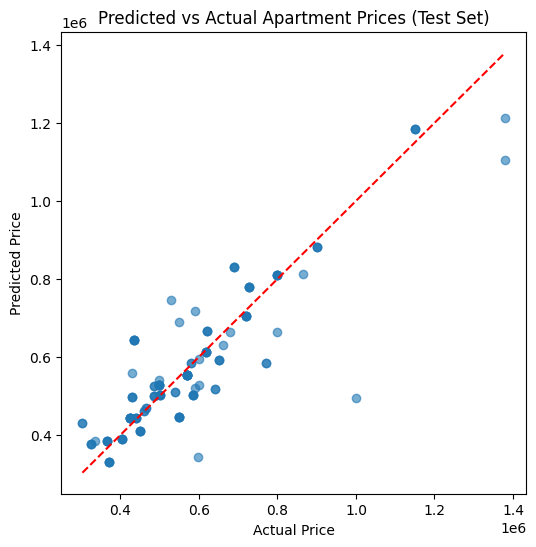

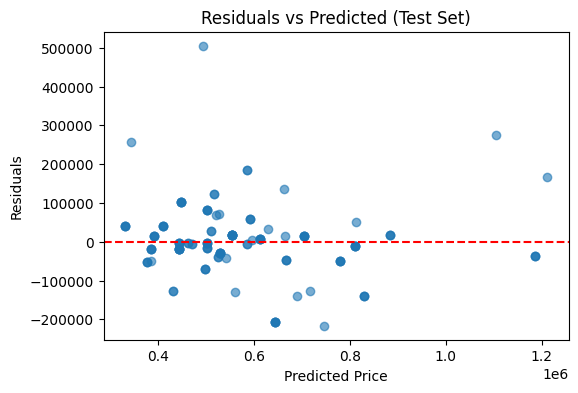

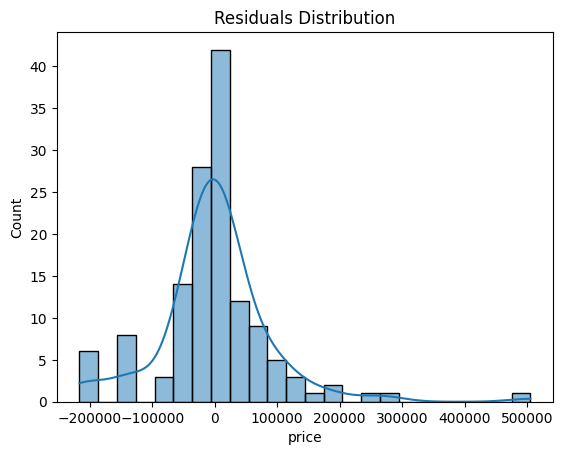

In [37]:
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_white

# Fit linear regression model with statsmodels to get residuals and design matrix
X_sm = sm.add_constant(X_train_scaled)  # add intercept
model_sm = sm.OLS(y_train, X_sm).fit()

# Get residuals
residuals_train = model_sm.resid  # from statsmodels model (train only)
exog_train = model_sm.model.exog

white_test = het_white(residuals_train, exog_train)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print("White’s test for heteroskedasticity (train data):")
print(dict(zip(labels, white_test)))

# Predicted vs Actual (on TEST data) 
y_pred = model.predict(X_test_scaled)  # use scaled test data if model trained on scaled
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Apartment Prices (Test Set)")
plt.show()

# Residuals vs Predicted (on TEST data)
residuals_test = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Test Set)")
plt.show()

import seaborn as sns

sns.histplot(residuals_test, kde=True)
plt.title("Residuals Distribution")
plt.show()





## FIXING HETERSOSCEDASTICITY OF THE RESIDUALS

The linear model modified with interaction and polynomial terms show heteroscedasticity with White's test. I will attempt to correct it with WLS.

WLS-log model summary:
                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.953
Model:                            WLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:22:46   Log-Likelihood:                -630.82
No. Observations:                 540   AIC:                             1284.
Df Residuals:                     529   BIC:                             1331.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

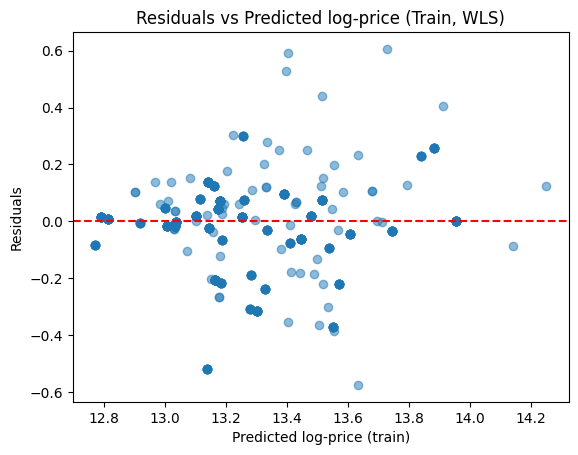

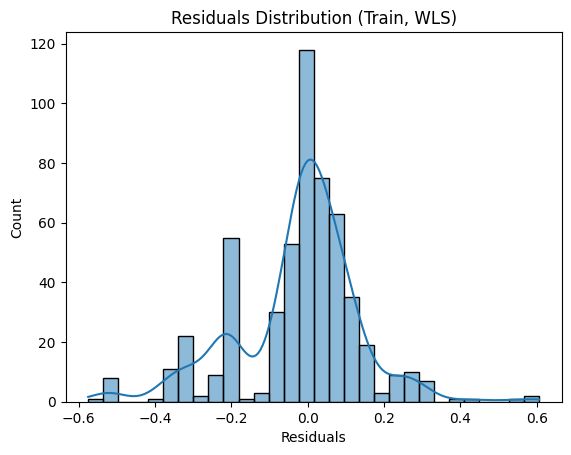

R² on log scale - train: 0.756, test: 0.717


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# 1. Train/test split

X = df_encoded[feature_cols]
y = df_encoded['price']

# Optional: scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 2. Log-transform target (train only)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


# 3. Fit initial OLS on training log-price

X_train_sm = sm.add_constant(X_train)
ols_log = sm.OLS(y_train_log, X_train_sm).fit()
residuals_log = ols_log.resid


# 4. Estimate variance for WLS weights

residuals_log_sq = residuals_log ** 2
aux_model = sm.OLS(residuals_log_sq, X_train_sm).fit()
fitted_var = aux_model.fittedvalues
weights = 1 / np.maximum(fitted_var, 1e-6)  # avoid division by zero

# 5. Fit WLS on log-price

wls_log = sm.WLS(y_train_log, X_train_sm, weights=weights).fit()
print("WLS-log model summary:")
print(wls_log.summary())

# 6. Predict on train and test

# Train predictions
y_train_log_pred = wls_log.predict(X_train_sm)
y_train_pred = np.expm1(y_train_log_pred)

# Test predictions
X_test_sm = sm.add_constant(X_test)
y_test_log_pred = wls_log.predict(X_test_sm)
y_test_pred = np.expm1(y_test_log_pred)


# 7. Residuals

residuals_train = y_train_log - y_train_log_pred
residuals_test = y_test_log - y_test_log_pred


# 8. White test for heteroskedasticity (train)

white_test_wls = het_white(residuals_train, X_train_sm)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print("White's test (train WLS-log):", dict(zip(labels, white_test_wls)))


# 9. Residual plots

# Residuals vs predicted (train)
plt.scatter(y_train_log_pred, residuals_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log-price (train)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted log-price (Train, WLS)')
plt.show()

# Residuals histogram (train)
import seaborn as sns
sns.histplot(residuals_train, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Residuals Distribution (Train, WLS)')
plt.show()


# 10. R²

r2_train_log = r2_score(y_train_log, y_train_log_pred)
r2_test_log = r2_score(y_test_log, y_test_log_pred)
print(f"R² on log scale - train: {r2_train_log:.3f}, test: {r2_test_log:.3f}")


## RESULTS

The R-Squared has significantly improved.

I used log-transformed price in order to compress the larger values and try to reduce heteroscedascity. Then I proceeded to use WLS on the log-price model. I tested the corrected model for heteroscedasticity with White's test. 
Despite the attempts at correcting the model, I still had to reject the null hypothesis of homoscedasticity (F-test p-value < 0.01). 

Heteroscedasticity casues the standard errors, confidence intervals, and significance tests to be unreliable.

The model is build using a limited set of variables, which do not fully capture the full range of factors contributing to price formation. As a result, the model might systematically under- or overpredict prices for certain segments of the data, especially at the extremes. 